In [1]:
# Including libraries 
library(dplyr)
library(tidyr)
library(stringr)
library(geohash)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
# Download data from the links provided
library(downloader)
# Blight Violations
dbvurl <- "https://d18ky98rnyall9.cloudfront.net/_97bd1c1e5df9537bb13398c9898deed7_detroit-blight-violations.csv?Expires=1487808000&Signature=gHUOfvUDTW-h~HuT0YXBeapK~jrxVV~G~ItLJCGvxfndaU-ZnP0OI1lurvBMMbxRy3JymGjsyrfMZvY8uXkywWwOeRT3JzfyXftxHVbDpw6rRsfOgmR0Bwu6HHIbcSSANPjFG9p6FwpQh1YyJUKvMj8IQCoaanPuG10SRLWg7Bc_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DBVFileName <- "detroit-blight-violations.csv"
if (!file.exists(DBVFileName)) 
    download(dbvurl, DBVFileName)
detBlightViol <- read.csv("detroit-blight-violations.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )   
    
# Detroit Demolition Permits 
ddpurl <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-demolition-permits.tsv?Expires=1487808000&Signature=GIkiK8yRf70Fya8VNatb9t~lXh5VD4kX05GZMKlqb3l2lX-z9aXk4okJQao6dOfApCcdgM~-6L3KlBG1YKhFbCKQqagI2ALjFt-PTkJeCyfPFSQ5FqMcQlh7qUClpZCH7F~zJA9X-vutv6IIaS-tKt22sAGgwu9X6lCtw6raPBo_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DDPFileName <- "detroit-demolition-permits.tsv"
if (!file.exists(DDPFileName)) 
    download(ddpurl, DDPFileName)
detDemolitionPermit <- read.delim("detroit-demolition-permits.tsv", header=TRUE, allowEscapes=FALSE, sep="\t", na.strings="", comment.char="")

    
# Detroit 311 calls
d311url <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-311.csv?Expires=1487808000&Signature=PTTniMA9xRitX6DycZSOORb45gCHgqeHDQABaMn54N6CswNJmFIXEYolvrWNCXlp~K4gn9zaSUOm27eQJhmEg4n7FUTJ5ZrWnVWBOfFRxouPgcglrdqUHfx-HKqnTMByfTLcEPmEqhZLKg7d9SLYsx4Cc2vwxCFshMjhpEF7ZwA_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
D311FileName <- "detroit-311.csv"
if (!file.exists(D311FileName)) 
    download(d311url, D311FileName)
det311 <- read.csv("detroit-311.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )  

# Detroit Crime 
dcrurl <- "https://d18ky98rnyall9.cloudfront.net/_dcebfb2135a2bf5a6392493bd61aba22_detroit-crime.csv?Expires=1487808000&Signature=POU~pk3A00i-iFJpAT9ytnBpfygEdMrPcITocHFPPHbyHegki~dcECrUD1kWApMOYmymWt2Vrm5c5mWmKG1pwpIaMPLwFGkF5kUkMTgCLuask2b0LnKcDOI86WzRYmkBsN2VvSQxXNK9y8CvCs2pUVzmwYbwGwstsOqbZei-Ohg_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A"
DCRFileName <- "detroit-crime.csv"
if (!file.exists(DCRFileName)) 
    download(dcrurl, DCRFileName)
detCrime <- read.csv("detroit-crime.csv", stringsAsFactors = FALSE,
                  strip.white = TRUE, na.strings ='' )    
       

In [3]:
#dplyr mutate to extract (LAT,LNG) from ViolationAddress. 
detBlightViol <- detBlightViol %>%
    #filter(TicketIssuedDT > "2005-01-01" & TicketIssuedDT <"2018-01-01") %>%
    mutate(latlng = gsub(".*\\n", "", ViolationAddress)) %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    filter(latlng != 'character(0)') %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    separate(latlng, c('LAT', 'LNG'), ', ')

#dplyr mutate to extract (LAT,LNG) from site_location
detDemolitionPermit <- detDemolitionPermit %>%
    mutate(latlng = gsub(".*\\n", "", site_location)) %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    filter(latlng != 'character(0)') %>%
    transform(latlng = gsub('[()]','', latlng)) %>%
    separate(latlng, c('LAT', 'LNG'), ', ')


Warning message:
“Too few values at 14 locations: 18, 23, 28, 88, 89, 94, 99, 144, 172, 189, 194, 206, 227, 335”

Loading required package: sp
Checking rgeos availability: FALSE
 	Note: when rgeos is not available, polygon geometry 	computations in maptools depend on gpclib,
 	which has a restricted licence. It is disabled by default;
 	to enable gpclib, type gpclibPermit()
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=Detroit&zoom=11&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Detroit&sensor=false
Warning message:
“Removed 2923 rows containing missing values (geom_point).”

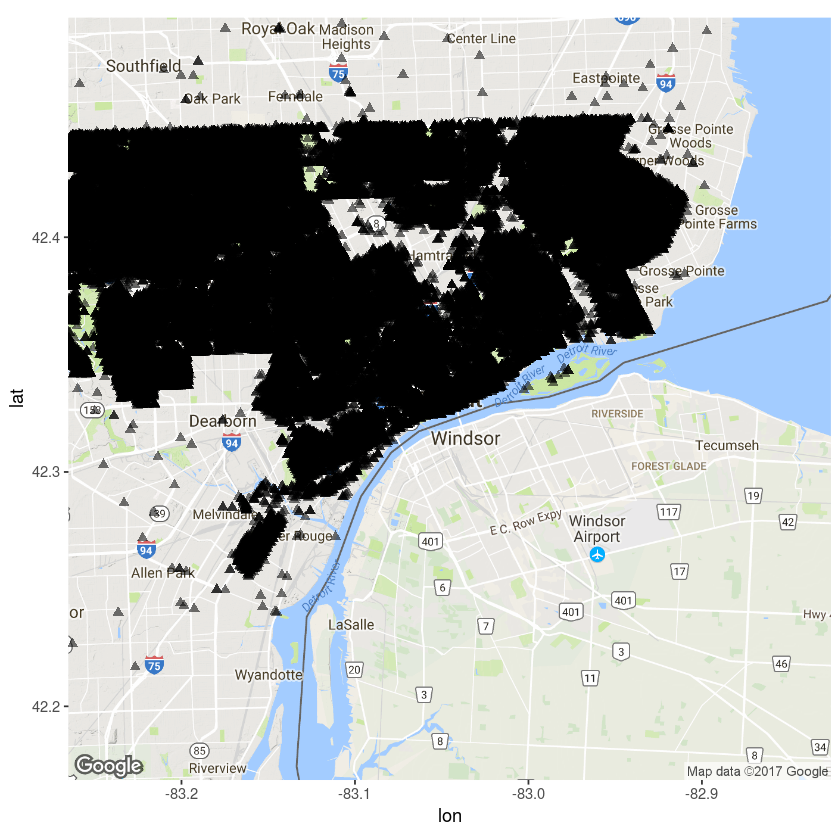

In [4]:
#Visualize to glance through the data
library(ggplot2)
library(ggmap)
library(maps)
library(maptools)

# get Google map to plot the data into it
detroit_map <- get_map(location = "Detroit", zoom = 11,
                      maptype = "t", scale = 2)
#Crime incidents
ggmap(detroit_map) +
  geom_point(data = detCrime, aes(x = detCrime$LON, y = detCrime$LAT, fill = "red", alpha = 0.8), size = 2, shape = 17) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

Warning message:
“Removed 404 rows containing missing values (geom_point).”

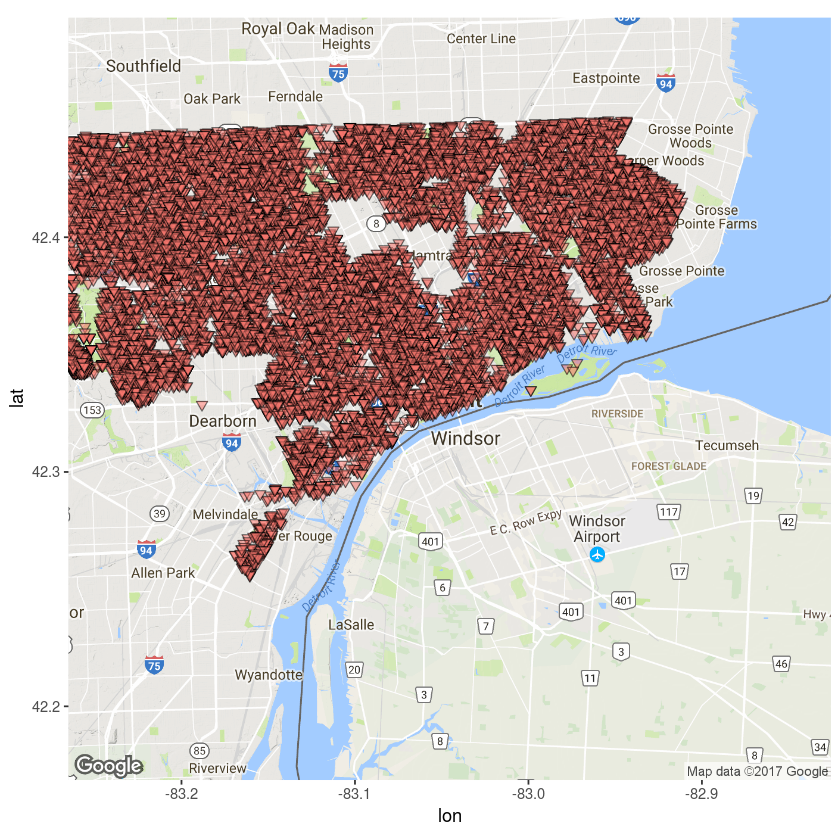

In [5]:
#311 Calls
ggmap(detroit_map) +
  geom_point(data = det311, aes(x = det311$lng, y = det311$lat, fill = "green", alpha = 0.8), size = 2, shape = 25) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

Warning message:
“Removed 3864 rows containing missing values (geom_point).”

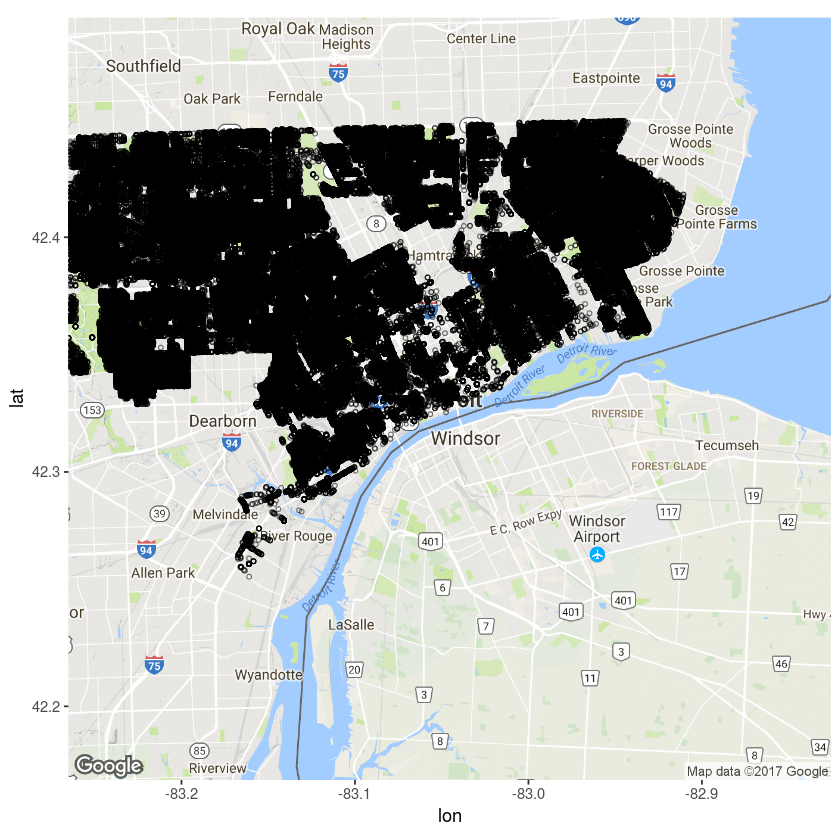

In [6]:
#Blight Violation
blight_viols <- detBlightViol %>%
  transform(LNG = as.numeric(LNG),
            LAT = as.numeric(LAT))

ggmap(detroit_map) +
  geom_point(data = blight_viols, aes(x = blight_viols$LNG, y = blight_viols$LAT, alpha = 0.1), size = 1, shape = 1) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

Warning message:
“Removed 77 rows containing missing values (geom_point).”

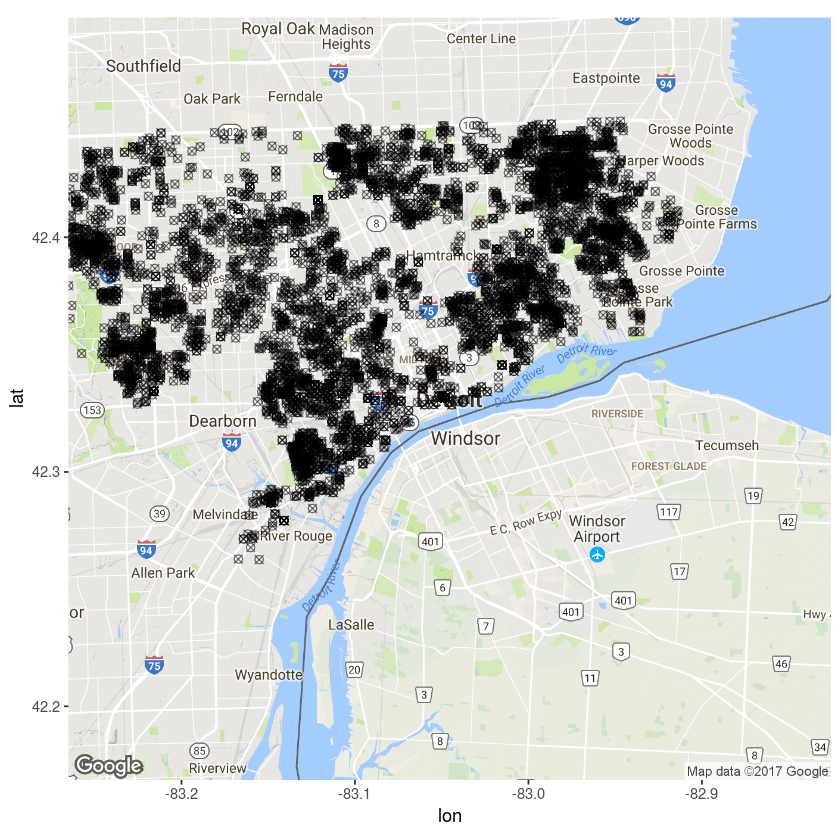

In [7]:
#Demolition permits
demo_permits <- detDemolitionPermit %>%
  transform(LNG = as.numeric(LNG),
            LAT = as.numeric(LAT))
ggmap(detroit_map) +
  geom_point(data = demo_permits, aes(x = LNG, y = LAT, fill = "yellow", alpha = 0.8), size = 2, shape = 13) +
  guides(fill=FALSE, alpha=FALSE, size=FALSE)

Warning message:
“Removed 3864 rows containing non-finite values (stat_density2d).”Warning message:
“Removed 77 rows containing non-finite values (stat_density2d).”

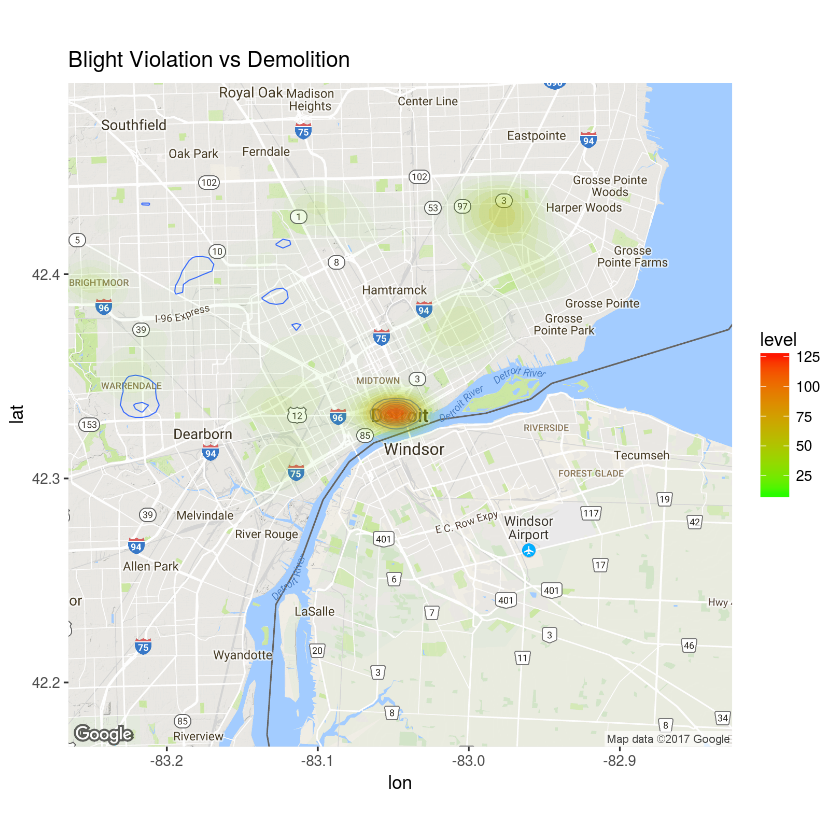

In [8]:
#Plot Blight violations with Demolition permits
ggmap(detroit_map) + #geom_point(data=call311_dat, aes(x=lng, y=lat), color="dark green", alpha=.1, size=1.1) +
  geom_density2d(data=blight_viols, aes(x=blight_viols$LNG, y=blight_viols$LAT), size = 0.3) + 
  stat_density2d(data=demo_permits, aes(x=demo_permits$LNG, y=demo_permits$LAT, fill = ..level.., alpha = ..level..), size = 0.01, bins = 16, geom = "polygon") + 
  scale_fill_gradient(low = "green", high = "red") + 
  scale_alpha(range = c(0, 0.3), guide = FALSE) + labs(title="Blight Violation vs Demolition")

In [9]:
#dplyr filter to create gh_8 gh_7 and uid colums 
detBlightViol <- detBlightViol %>%    
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LNG), 8),
           gh_7 = gh_encode(as.numeric(LAT), as.numeric(LNG), 7),
           uid = paste0('blightviol_',row_number()))

detDemolitionPermit <- detDemolitionPermit %>%
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LNG), 8),
           gh_7 = gh_encode(as.numeric(LAT), as.numeric(LNG), 7),
           uid = paste0('demolper',row_number()))

det311 <- det311 %>%
    mutate(gh_8 = gh_encode(as.numeric(lat), as.numeric(lng), 8),
           gh_7 = gh_encode(as.numeric(lat), as.numeric(lng), 7),
           uid = paste0('det311',row_number()))

detCrime <- detCrime %>%
    mutate(gh_8 = gh_encode(as.numeric(LAT), as.numeric(LON), 8),
           gh_7 = gh_encode(as.numeric(LAT), as.numeric(LON), 7),
           uid = paste0('detcrim',row_number()))

In [10]:
#Summarize records based on gh_8
dbv_gh_8_grp <- detBlightViol %>%
    group_by(gh_8) %>%
    summarize(dbv_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(dbv_ngbr_8_ct))

#mutate(PERMIT_ISSUED=min(as.Date(detDemolitionPermit$PERMIT_ISSUED,format='%m/%d/%Y'), na.rm=TRUE)) %>%
ddp_gh_8_grp <- detDemolitionPermit %>%    
    group_by(gh_8) %>%
    summarize(ddp_ngbr_8_ct = n()) %>% 
    arrange(gh_8,desc(ddp_ngbr_8_ct))

#Summarize dates for survival analysis
ddp_gh_8_grp_d <- detDemolitionPermit %>%    
    group_by(gh_8) %>%
    summarize(M_PERMIT_ISSUED=mean(as.numeric(PERMIT_ISSUED,format='%m/%d/%Y'), na.rm=TRUE)) 

d311_gh_8_grp <- det311 %>%
    group_by(gh_8) %>%
    summarize(d311_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(d311_ngbr_8_ct))

dcr_gh_8_grp <- detCrime %>%
    group_by(gh_8) %>%
    summarize(dcr_ngbr_8_ct = n()) %>%
    arrange(gh_8,desc(dcr_ngbr_8_ct))


In [11]:
dbv_gh_7_grp <- detBlightViol %>%
    group_by(gh_7) %>%
    summarize(dbv_ngbr_7_ct = n()) %>%
    arrange(gh_7,desc(dbv_ngbr_7_ct))

ddp_gh_7_grp <- detDemolitionPermit %>%
    group_by(gh_7) %>%
    summarize(ddp_ngbr_7_ct = n()) %>%
    arrange(gh_7,desc(ddp_ngbr_7_ct))

d311_gh_7_grp <- det311 %>%
    group_by(gh_7) %>%
    summarize(d311_ngbr_7_ct = n()) %>%
    arrange(gh_7,desc(d311_ngbr_7_ct))

dcr_gh_7_grp <- detCrime %>%
    group_by(gh_7) %>%
    summarize(dcr_ngbr_7_ct = n()) %>%
    arrange(gh_7,desc(dcr_ngbr_7_ct))

In [12]:
#join counts and demolished dates based on gh_8
detBlightViolV <- left_join(detBlightViol, dbv_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVD <- left_join(detBlightViolV, ddp_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVDD <- left_join(detBlightViolVD, ddp_gh_8_grp_d, by = c("gh_8" = "gh_8"))
detBlightViolVD3 <- left_join(detBlightViolVDD, d311_gh_8_grp, by = c("gh_8" = "gh_8"))
detBlightViolVD3C <- left_join(detBlightViolVD3, dcr_gh_8_grp, by = c("gh_8" = "gh_8"))


In [13]:
#Keeping only the colums required for analysis
keep <- c("LAT","LNG","gh_8", "gh_7", "dbv_ngbr_8_ct", "ddp_ngbr_8_ct", "d311_ngbr_8_ct", "dcr_ngbr_8_ct",  "ViolationCategory", "CleanUpCost", "JudgmentAmt", "PaymentStatus", "FineAmt", "AdminFee", "LateFee", "AgencyName", "TicketIssuedDT", "M_PERMIT_ISSUED")
detBlightViolVD3C <- detBlightViolVD3C[keep]

# Assing values
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="PAID IN FULL"] <- 1
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="PARTIAL PAYMENT MADE"] <- 2
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="NO PAYMENT APPLIED"] <- 3
detBlightViolVD3C$PaymentStatus[detBlightViolVD3C$PaymentStatus=="NO PAYMENT ON RECORD"] <- 4

detBlightViolVD3C$PaymentStatus <- as.numeric(detBlightViolVD3C$PaymentStatus)

detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Department of Public Works"] <- 1
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Building and Safety Engineering Department"] <- 2
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Health Department"] <- 3
detBlightViolVD3C$AgencyName[detBlightViolVD3C$AgencyName=="Detroit Police Department"] <- 4

#Data Cleanup
detBlightViolVD3C$AgencyName[is.na(detBlightViolVD3C$AgencyName)] <- as.numeric(0)
detBlightViolVD3C$AgencyName <- as.numeric(detBlightViolVD3C$AgencyName)
detBlightViolVD3C$AgencyName[is.na(detBlightViolVD3C$AgencyName)] <- as.numeric(0)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”

In [14]:
# Data preparation to avoid non-numerics from the dataset
ifelse ((!is.na(detBlightViolVD3C$CleanUpCost) || detBlightViolVD3C$CleanUpCost != ""),
    detBlightViolVD3C$CleanUpCost <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$CleanUpCost)))),
    detBlightViolVD3C$CleanUpCost <- as.numeric(0))
    
ifelse ((!is.na(detBlightViolVD3C$JudgmentAmt) || detBlightViolVD3C$JudgmentAmt != ""),
    detBlightViolVD3C$JudgmentAmt <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$JudgmentAmt)))),
    detBlightViolVD3C$JudgmentAmt <- as.numeric(0))
detBlightViolVD3C$JudgmentAmt[is.na(detBlightViolVD3C$JudgmentAmt)] <- as.numeric(0)

ifelse ((!is.na(detBlightViolVD3C$FineAmt) || detBlightViolVD3C$FineAmt != ""),
    detBlightViolVD3C$FineAmt <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$FineAmt)))),
    detBlightViolVD3C$FineAmt <- as.numeric(0))
detBlightViolVD3C$FineAmt[is.na(detBlightViolVD3C$FineAmt)] <- as.numeric(0)

ifelse ((!is.na(detBlightViolVD3C$AdminFee) || detBlightViolVD3C$AdminFee != ""),
    detBlightViolVD3C$AdminFee <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$AdminFee)))),
    detBlightViolVD3C$AdminFee <- as.numeric(0))

ifelse ((!is.na(detBlightViolVD3C$LateFee) || detBlightViolVD3C$LateFee != ""),
    detBlightViolVD3C$LateFee <- as.numeric(sub('\\$','',(as.character(detBlightViolVD3C$LateFee)))),
    detBlightViolVD3C$LateFee <- as.numeric(0))

detBlightViolVD3C$ddp_ngbr_8_ct[is.na(detBlightViolVD3C$ddp_ngbr_8_ct)] <- as.numeric(0)
detBlightViolVD3C$d311_ngbr_8_ct[is.na(detBlightViolVD3C$d311_ngbr_8_ct)] <- as.numeric(0)
detBlightViolVD3C$dcr_ngbr_8_ct[is.na(detBlightViolVD3C$dcr_ngbr_8_ct)] <- as.numeric(0)

detBlightViolVD3C$Demolished[detBlightViolVD3C$ddp_ngbr_8_ct >0 ] <- 1
detBlightViolVD3C$Demolished[detBlightViolVD3C$ddp_ngbr_8_ct <=0 ] <- 0

ifelse ((!is.na(detBlightViolVD3C$TicketIssuedDT) || detBlightViolVD3C$TicketIssuedDT != ""),
        detBlightViolVD3C$TicketIssuedDT <- as.numeric(as.Date(detBlightViolVD3C$TicketIssuedDT,"%m/%d/%Y %H:%M:%S")),
        detBlightViolVD3C$TicketIssuedDT <- as.numeric(0))

ifelse ((!is.na(detBlightViolVD3C$M_PERMIT_ISSUED) || detBlightViolVD3C$M_PERMIT_ISSUED != ""),
        detBlightViolVD3C$M_PERMIT_ISSUED <- as.numeric(detBlightViolVD3C$M_PERMIT_ISSUED),
        detBlightViolVD3C$M_PERMIT_ISSUED <- as.numeric(0))        

nrow(detBlightViolVD3C)
summary(detBlightViolVD3C)


[1] 0

[1] 1680

[1] 1500

[1] 20

[1] 150

[1] NA

[1] NA

[1] 307804

     LAT                LNG                gh_8               gh_7          
 Length:307804      Length:307804      Length:307804      Length:307804     
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
 dbv_ngbr_8_ct   ddp_ngbr_8_ct    d311_ngbr_8_ct    dcr_ngbr_8_ct    
 Min.   :    1   Min.   :  0.00   Min.   : 0.0000   Min.   : 0.0000  
 1st Qu.:    4   1st Qu.:  0.00   1st Qu.: 0.0000   1st Qu.: 0.0000  
 Median :    7   Median :  0.00   Median : 0.0000   Median : 0.0000  
 Mean   : 1562   Mean   : 38.37   Mean   : 0.0419   Mean   : 0.8085  
 3rd Qu.:   14   3rd Qu.:  0.00   

In [15]:
#Summarize based on gh_8
detBlightViolVD3C <- detBlightViolVD3C %>%
      group_by(gh_8) %>%
      summarize(m_dbv_ngbr_8_ct=mean(dbv_ngbr_8_ct, na.rm=TRUE), 
                m_ddp_ngbr_8_ct=mean(ddp_ngbr_8_ct, na.rm=TRUE),
                m_d311_ngbr_8_ct=mean(d311_ngbr_8_ct, na.rm=TRUE),
                m_ViolationCategory=max(ViolationCategory, na.rm=TRUE),
                s_CleanUpCost=sum(CleanUpCost, na.rm=TRUE),
                s_JudgmentAmt=sum(JudgmentAmt, na.rm=TRUE),
                m_PaymentStatus=mean(PaymentStatus, na.rm=TRUE),
                s_FineAmt=sum(FineAmt, na.rm=TRUE),
                s_LateFee=sum(LateFee, na.rm=TRUE),
                m_AgencyName=max(AgencyName, na.rm=TRUE),
                m_Demolished=max(Demolished, na.rm=TRUE),
                m_TicketIssuedDT= min(TicketIssuedDT,na.rm=TRUE ),
                M_M_PERMIT_ISSUED=min(M_PERMIT_ISSUED,na.rm=TRUE))


In [16]:
# Using SQL queries on dataset to understand data.
library(sqldf)
sqldf("select count(*) from 'detBlightViolVD3C' where m_Demolished=1")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: tcltk
Warning message:
“Quoted identifiers should have class SQL, use DBI::SQL() if the caller performs the quoting.”

count(*)
1 3142

In [17]:
# Training and test data
indexes = sample(nrow(detBlightViolVD3C), size=0.1*nrow(detBlightViolVD3C))
train = detBlightViolVD3C[indexes,]
test = detBlightViolVD3C[-indexes,]

In [18]:
# Formula 
fol <- formula(m_Demolished ~ m_dbv_ngbr_8_ct + m_ddp_ngbr_8_ct + m_d311_ngbr_8_ct  +
                s_CleanUpCost + s_JudgmentAmt + m_PaymentStatus +
                s_FineAmt + s_LateFee + m_AgencyName )

In [19]:
#library(rpart)
#library(caret)

#rpModel <- rpart(fol, method="class", data=train, na.action = na.omit)
#summary(rpModel)
#rpPred <- predict(rpModel, newdata = test, na.action = na.omit)
#NOT WORKING

In [20]:
#Random forest model analysis
library(party)
library(randomForest)

rfModel <- randomForest(fol, data=train, na.action = na.omit)
print(rfModel)
rfPred <- predict(rfModel, newdata = test, na.action = na.omit)
rfTbl <- table(rfPred, test$m_Demolished)


Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: sandwich

Attaching package: ‘strucchange’

The following object is masked from ‘package:stringr’:

    boundary

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine

Warning message in randomForest.default(m, y, ...):
“The response has five or fewer unique values.  Are you sure you want to do regression?”


Call:
 randomForest(formula = fol, data = train, na.action = na.omit) 
               Type of random forest: regression
                     Number of trees: 500
No. of variables tried at each split: 3

          Mean of squared residuals: 5.697523e-05
                    % Var explained: 99.87


In [30]:
head(rfTbl)

                       
rfPred                    0   1
  -1.21277987652491e-16 414   0
  -1.17739151761498e-16   1   0
  -1.17530984944381e-16   1   0
  -1.17267306976032e-16   1   0
  -1.17253429188224e-16   1   0
  -1.17100773522338e-16   1   0

In [21]:
#chi-squre analysis
library(MASS)
print(chisq.test(test$m_Demolished, test$m_ddp_ngbr_8_ct))


Attaching package: ‘MASS’

The following object is masked from ‘package:dplyr’:

    select

Warning message in chisq.test(test$m_Demolished, test$m_ddp_ngbr_8_ct):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  test$m_Demolished and test$m_ddp_ngbr_8_ct
X-squared = 61177, df = 13, p-value < 2.2e-16



In [22]:
library("survival")
survfit(Surv(test$m_TicketIssuedDT,test$m_Demolished == 0)~1)

Call: survfit(formula = Surv(test$m_TicketIssuedDT, test$m_Demolished == 
    0) ~ 1)

   4490 observations deleted due to missingness 
      n  events  median 0.95LCL 0.95UCL 
  56687   53996   13906   13895   13913 

In [23]:
library("xgboost")

xKeep <- c( "m_dbv_ngbr_8_ct","m_ddp_ngbr_8_ct","m_d311_ngbr_8_ct","m_ViolationCategory","s_LateFee","s_FineAmt","s_JudgmentAmt","s_CleanUpCost",
           "m_PaymentStatus","m_AgencyName","m_Demolished")
xtrain <- train[xKeep]
xtest <- test[xKeep]

trainMatrix <- as.matrix(xtrain)
testMatrix <- as.matrix(xtest)

xgb <- xgboost(data = data.matrix(xtrain[,-1]), 
 label =xtrain$m_Demolished , 
 eta = 0.1,
 max_depth = 15, 
 nround=10, 
 subsample = 0.5,
 colsample_bytree = 0.5,
 seed = 1,
 eval_metric = "mlogloss",
 objective = "multi:softprob",
 num_class = 100,
 nthread = 2
)


Attaching package: ‘xgboost’

The following object is masked from ‘package:dplyr’:

    slice



[1]	train-mlogloss:0.551635 
[2]	train-mlogloss:0.495870 
[3]	train-mlogloss:0.448311 
[4]	train-mlogloss:0.404216 
[5]	train-mlogloss:0.364788 
[6]	train-mlogloss:0.329524 
[7]	train-mlogloss:0.297907 
[8]	train-mlogloss:0.269515 
[9]	train-mlogloss:0.243987 
[10]	train-mlogloss:0.221007 


In [24]:
dim(xtest)
pred <- predict(xgb, t(xtest[1,7]))

print(head(pred))

[1] 61177    11

[1] 0.733373582 0.007193833 0.002647409 0.002647450 0.002647434 0.002647098


In [25]:
model <- xgb.dump(xgb, with.stats = T)
model[1:10]


Warning message:
“'with.stats' is deprecated.
Use 'with_stats' instead.
See help("Deprecated") and help("xgboost-deprecated").”

[1] "booster[0]"                                                
 [2] "0:[f9<0.5] yes=1,no=2,missing=1,gain=7242.32,cover=66.2706"
 [3] "1:leaf=4.92212,cover=63.2016"                              
 [4] "2:leaf=-0.0380929,cover=3.069"                             
 [5] "booster[1]"                                                
 [6] "0:[f9<0.5] yes=1,no=2,missing=1,gain=5721.53,cover=68.0526"
 [7] "1:leaf=-0.0497389,cover=64.9242"                           
 [8] "2:leaf=3.78888,cover=3.1284"                               
 [9] "booster[2]"                                                
[10] "0:leaf=-0.0497558,cover=66.4092"

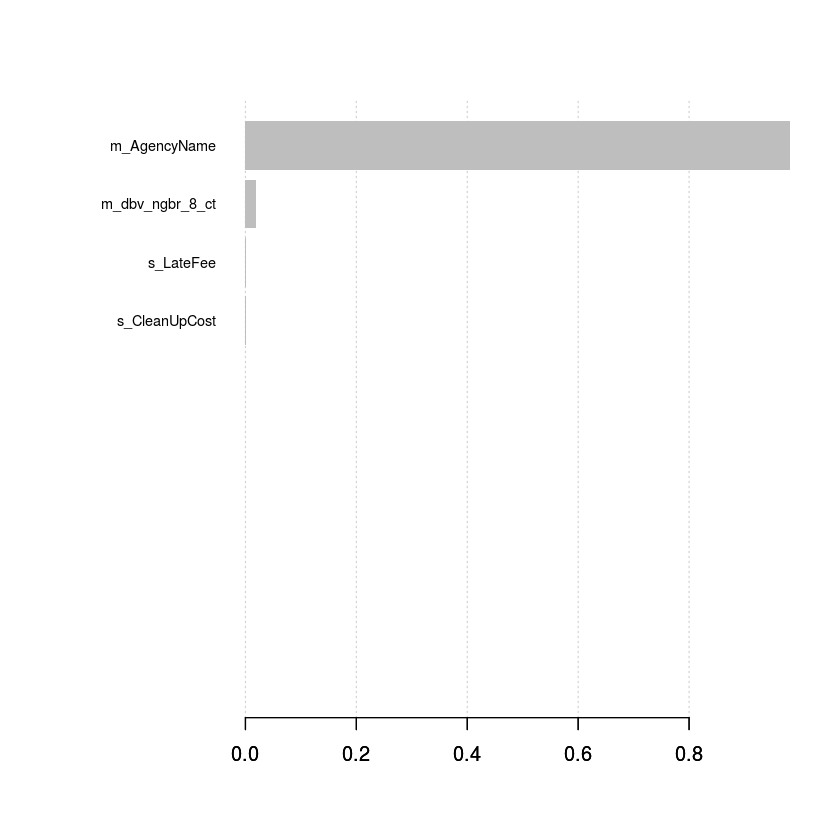

In [26]:
# Get the feature real names
names <- dimnames(trainMatrix)[[2]]

# Compute feature importance matrix
importance_matrix <- xgb.importance(names, model = xgb)

# Nice graph
xgb.plot.importance(importance_matrix[1:10,])